In [1]:
import mdtraj as md
from simtk.openmm.app import PDBFile
from pdbfixer import PDBFixer

In [2]:
topology = md.load('digoxin_12.76_3l0j_noH.pdb')
trajectory = md.load('digoxin_12.76_3l0j_noH_trajectory.dcd', top = topology)

In [3]:
heavy_atoms = [atom.index for atom in topology.topology.atoms if atom.element.symbol != 'H']
residues = list(topology.topology.residues)
ligand_atoms = [atom.index for atom in residues[-1].atoms]
rmsdFunctionHeavy = md.rmsd(trajectory, trajectory[0], 0, atom_indices = heavy_atoms)
rmsdFunctionAll = md.rmsd(trajectory, trajectory[0], 0, atom_indices = None)
rmsdLigand = md.rmsd(trajectory, trajectory[0], 0, atom_indices = ligand_atoms)

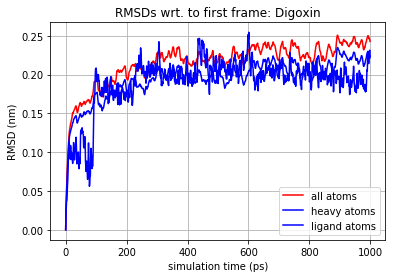

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(trajectory.time, rmsdFunctionAll, 'r', label='all atoms')
plt.plot(trajectory.time, rmsdFunctionHeavy, 'b', label='heavy atoms')
plt.plot(trajectory.time, rmsdLigand, 'b', label='ligand atoms')
plt.legend()
plt.title('RMSDs wrt. to first frame: Digoxin')
plt.xlabel('simulation time (ps)')
plt.ylabel('RMSD (nm)')
plt.grid(True)

In [5]:
removeHeterogenes = False
for frame in trajectory[-1]:
    frame.save('digoxin_lastFrame.pdb')
    if (removeHeterogenes):
        fixer = PDBFixer('digoxin_lastFrame.pdb')
        fixer.removeHeterogens(True)
        PDBFile.writeFile(fixer.topology, fixer.positions, open('digoxin_lastFrame.pdb', 'w'))

In [6]:
topology = md.load('AZ5104_8.43_withH_3l0j_noH.pdb')
trajectory = md.load('AZ5104_8.43_withH_3l0j_noH_trajectory.dcd', top = topology)

In [7]:
heavy_atoms = [atom.index for atom in topology.topology.atoms if atom.element.symbol != 'H']
residues = list(topology.topology.residues)
ligand_atoms = [atom.index for atom in residues[-1].atoms]
rmsdFunctionHeavy = md.rmsd(trajectory, trajectory[0], 0, atom_indices = heavy_atoms)
rmsdFunctionAll = md.rmsd(trajectory, trajectory[0], 0, atom_indices = None)
rmsdLigand = md.rmsd(trajectory, trajectory[0], 0, atom_indices = ligand_atoms)

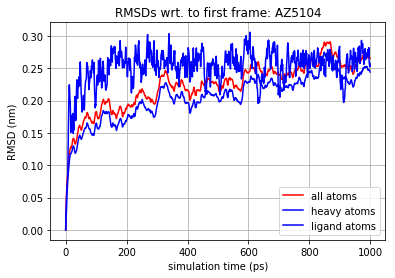

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(trajectory.time, rmsdFunctionAll, 'r', label='all atoms')
plt.plot(trajectory.time, rmsdFunctionHeavy, 'b', label='heavy atoms')
plt.plot(trajectory.time, rmsdLigand, 'b', label='ligand atoms')
plt.legend()
plt.title('RMSDs wrt. to first frame: AZ5104')
plt.xlabel('simulation time (ps)')
plt.ylabel('RMSD (nm)')
plt.grid(True)

In [9]:
removeHeterogenes = False
for frame in trajectory[-1]:
    frame.save('AZ5104_lastFrame.pdb')
    if (removeHeterogenes):
        fixer = PDBFixer('AZ5104_lastFrame.pdb')
        fixer.removeHeterogens(True)
        PDBFile.writeFile(fixer.topology, fixer.positions, open('AZ5104_lastFrame.pdb', 'w'))

In [10]:
from Bio.PDB import *
from Bio import *
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder

In [11]:
def getMacromoleculeStatistics(macromolecule):
    for model in macromolecule.get_models():
        print("model ", model.id) 
        for chain in model.get_chains():
            print("chain ", chain.id, len(list(chain.get_residues())), "residues")
            residuesPerChain = []
            for residue in chain.get_residues():
                residuesPerChain.append(residue.get_resname())
            print(pd.unique(residuesPerChain))

def findNonStandardResidues(macromolecule):
    nonStandardResidues = {}
    for model in macromolecule.get_models():
        print("model: ", model.id)
        for chain in model.get_chains():
            print("chain: ", chain.id)
            nonStandardResiduesPerChain = []
            for residue in chain:
                if (not (residue.id[0] in [' '])):
                    nonStandardResiduesPerChain.append(residue.id)
            nonStandardResidues[chain] = nonStandardResiduesPerChain
    return nonStandardResidues

def removeResidues(macromolecule, residues):
    for model in macromolecule.get_models():
        print("model: ", model.id)
        for chain in model.get_chains():
            nonStandardResiduesPerChain = residues[chain]
            print("chain: ", chain.id)
            for toBeRemoved in nonStandardResiduesPerChain:
                print("non-standard residue: ", toBeRemoved)
                chain.detach_child(toBeRemoved)

def getMacromoleculeBox(macromolecule):
    for model in macromolecule.get_models():
        print("model ", model.id)
        extreemeCoords = {}
        coordMin = [999, 999, 999]
        coordMax = [-999, -999, -999]
        for chain in model.get_chains():
            print("chain ", chain.id, len(list(chain.get_residues())), "residues")
            residuesPerChain = []
            for residue in chain.get_residues():
                for atom in residue.get_atoms():
                    #print(residue.get_resname(), atom.get_name(), atom.get_coord())
                    coords = atom.get_coord()
                    
                    for iii, (cooMin, cooMax, coo) in enumerate(zip(coordMin, coordMax, coords)):
                        coordMin[iii] = min(cooMin, float(coo))
                        coordMax[iii] = max(cooMax, float(coo))
                        
                    #print(coordMin)
        extreemeCoords[model.id] = [coordMin, coordMax]
    return extreemeCoords


In [22]:
import Bio.PDB
import numpy
from Bio.PDB import PDBIO

def residue_dist_to_ligand(protein_residue, ligand_residue) :
    #Returns distance from the protein C-alpha to the closest ligand atom
    dist = []
    for atom in ligand_residue :
        if "CA" in protein_residue:
            vector  = protein_residue["CA"].coord - atom.coord
            dist.append(numpy.sqrt(numpy.sum(vector * vector)))
            return min(dist)

def get_ligand_by_name(residue_name, model):
    #Extract ligands from all chains in a model by its name
    global ligands
    ligands = {}
    chains = model.child_dict
    for c in chains:
        ligands[c] = []
        for protein_res in chains[c].child_list:
            if protein_res.resname == residue_name:
                ligands[c].append(protein_res)
    return ligands

def get_ligand_by_chain(chain_name, model):
    #Extract all ligand residues from given chain name
    global ligands
    ligands = {}    
    ligands[chain_name] = []
    chains = model.child_dict
    for protein_res in chains[chain_name].child_list:
        ligands[chain_name].append(protein_res)
    return ligands

def active_site(ligands, distance, model):
    # Prints out residues located at a given distance from ligand
    chains = model.child_dict
    for group in ligands.values():
        for ligand_res in group:
            print("ligand residue: "+ligand_res.resname, ligand_res.id[1])
            for c in chains:
                for protein_res in chains[c].child_list:
                    if protein_res not in group:
                        dist = residue_dist_to_ligand(protein_res, ligand_res)
                        if dist and dist < distance :
                            print(protein_res.resname, protein_res.id[1], dist)


def save_ligand(structure, filename):
    # Saves ligand to a filename.pdb
    Select = Bio.PDB.Select
    class LigandSelect(Select):
        def accept_residue(self, residue):
            for group in ligands.values():
                if residue in group:
                    return 1
                else:
                    return 0
    io=PDBIO()
    io.set_structure(structure)
    io.save(filename+'.pdb', LigandSelect())

In [33]:
parser = PDBParser(QUIET=True)
system = parser.get_structure('AZ5104', 'AZ5104_lastFrame.pdb')

model = system[0]
ligand = get_ligand_by_name('XAZ', model)
active_site(ligand, 7.0, model)

ligand residue: XAZ 254
HIS 59 6.759227
ALA 63 5.2668567
ALA 104 5.7161694
PHE 113 6.1528616
PHE 114 6.4900813


In [32]:
parser = PDBParser(QUIET=True)
system = parser.get_structure('digoxin', 'digoxin_lastFrame.pdb')

model = system[0]
ligand = get_ligand_by_name('XDI', model)
active_site(ligand, 7.0, model)

ligand residue: XDI 254
CYS 21 6.6491556
GLN 22 6.171068
LEU 23 6.3440194
ALA 63 6.7322674


In [27]:
parser = PDBParser(QUIET=True)
system = parser.get_structure('digoxin', 'digoxin_lastFrame.pdb')

for model in system.get_models():
    for chain in model.get_chains():
            print("chain ", chain.id, len(list(chain.get_residues())), "residues")
            for residue in chain.get_residues():
                print(residue.get_resname())
                for atom in residue.get_atoms():
                    #print(residue.get_resname(), atom.get_name(), atom.get_coord())
                    coords = atom.get_coord()

chain  A 243 residues
ALA
SER
LEU
THR
GLU
ILE
GLU
HIS
LEU
VAL
GLN
SER
VAL
CYS
LYS
SER
TYR
ARG
GLU
THR
CYS
GLN
LEU
ARG
LEU
GLU
ASP
LEU
LEU
ARG
GLN
ARG
SER
ASN
ILE
PHE
SER
ARG
GLU
GLU
VAL
THR
GLY
TYR
GLN
ARG
LYS
SER
MET
TRP
GLU
MET
TRP
GLU
ARG
CYS
ALA
HIS
HIS
LEU
THR
GLU
ALA
ILE
GLN
TYR
VAL
VAL
GLU
PHE
ALA
LYS
ARG
LEU
SER
GLY
PHE
MET
GLU
LEU
CYS
GLN
ASN
ASP
GLN
ILE
VAL
LEU
LEU
LYS
ALA
GLY
ALA
MET
GLU
VAL
VAL
LEU
VAL
ARG
MET
CYS
ARG
ALA
TYR
ASN
ALA
ASP
ASN
ARG
THR
VAL
PHE
PHE
GLU
GLY
LYS
TYR
GLY
GLY
MET
GLU
LEU
PHE
ARG
ALA
LEU
GLY
CYS
SER
GLU
LEU
ILE
SER
SER
ILE
PHE
ASP
PHE
SER
HIS
SER
LEU
SER
ALA
LEU
HIS
PHE
SER
GLU
ASP
GLU
ILE
ALA
LEU
TYR
THR
ALA
LEU
VAL
LEU
ILE
ASN
ALA
HIS
ARG
PRO
GLY
LEU
GLN
GLU
LYS
ARG
LYS
VAL
GLU
GLN
LEU
GLN
TYR
ASN
LEU
GLU
LEU
ALA
PHE
HIS
HIS
HIS
LEU
CYS
LYS
THR
HIS
ARG
GLN
SER
ILE
LEU
ALA
LYS
LEU
PRO
PRO
LYS
GLY
LYS
LEU
ARG
SER
LEU
CYS
SER
GLN
HIS
VAL
GLU
ARG
LEU
GLN
ILE
PHE
GLN
HIS
LEU
HIS
PRO
ILE
VAL
VAL
GLN
ALA
ALA
PHE
PRO
PRO
LEU
TYR
LYS
GLU
LEU
PHE
SER
chain 

In [ ]:
atoms = list(topology.topology.atoms)
residues = list(topology.topology.residues)
atoms[0]

In [ ]:
from simtk.openmm.app import PDBFile
from pdbfixer import PDBFixer

for frame in trajectory[-1]:
    frame.save('AZ5104_lastFrame.pdb')
    #fixer = PDBFixer('frame.pdb')
    #fixer.removeHeterogens(True)
    #PDBFile.writeFile(fixer.topology, fixer.positions, open('frame.pdb', 'w'))
    